# Ingest Data

In [4]:
import os
import numpy as np
import pandas as pd
import dask.dataframe as dd

In [5]:
# set this to true to read from Open DataHub
USE_ODH = False

In [6]:
# location of dataset csv on datahub s3
BUCKET = "" # insert
PREFIX = "" # insert
FILENAME = "" # insert
ENDPOINT_URL = "" # insert
s3_path = "s3://" + os.path.join(BUCKET, PREFIX, FILENAME)
s3_path

's3://'

**NOTE** If reading data from Open DataHub, make sure that access id and secret key are stored as one of the following ways:

1. Inside `~/.aws/credentials` or `~/.aws/config` or `/etc/boto.cfg` or `~/.boto` as `aws_access_key_id=foobar` and `aws_secret_access_key=verysecret`
2. Environment variables `AWS_ACCESS_KEY_ID=foobar` and `AWS_SECRET_ACCESS_KEY=verysecret`
3. (NOT RECOMMENDED) Plain text string arguments in `storage_options` dict of `dask.dataframe.read_csv`

In [7]:
# read in from s3
if USE_ODH:
  df = dd.read_csv(
      s3_path,
      header=None,
      storage_options={
          "client_kwargs": {"endpoint_url": ENDPOINT_URL}
      }
  )
  # data is small enough to be fit in memory
  df = df.compute()
  
  df_trial = dd.read_csv(
      s3_path,
      header=None,
      storage_options={
          "client_kwargs": {"endpoint_url": ENDPOINT_URL}
      }
  )
  # data is small enough to be fit in memory
  df_trial = df_trial.compute()
else:
  df = pd.read_csv('allDogs.csv', header=None)
  df_trial = pd.read_csv('trialDogs.csv', header=None)
  
# prettify df
df = df.transpose()
new_header = df.iloc[0] 
df = df[1:] 
df.columns = new_header

# read in trial csv
df_trial = df_trial.transpose()
new_header = df_trial.iloc[0] 
df_trial = df_trial[1:] 
df_trial.columns = new_header

In [22]:
df_trial.head(25)

,Dog,Mass,Calories,Fat,Cholesterol,Sodium,Potassium,Carbohydrates,Protein,Temp
1,Smart Dogs Veggie Hot Dogs,42,50,2,0,0.33,0.16,2,7,193
2,Franks Ball Park,53,130,11,0.045,0.48,0,2,5,193
3,Hebrew National,49,150,13,0.025,450,0,2,6,193
4,Oscar Mayer,45,110,10,0.035,0.42,0,1,5,193


# Prepare + Preprocess Data

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

In [11]:
# split data and regressor variable
X_values = df.drop(['Time', 'Dog'], axis=1)
y_values = df['Time']

# clean trial data
X_trial = df_trial.drop(['Dog'], axis=1)

In [12]:
# one hot encode hotdog type
# X_values = X_values.join(pd.get_dummies(df['Dog'])).drop('Dog', axis=1)
# X_values.head()

In [13]:
# add polynomial features to help capture non linearity
poly_featurizer = PolynomialFeatures(degree=2)
X_values = poly_featurizer.fit_transform(X_values)

X_trial = poly_featurizer.fit_transform(X_trial)

In [14]:
# split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, random_state=24)

# Train Models

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sklearn.metrics import r2_score

In [16]:
# fit linear reg model
model = LinearRegression()
model.fit(X_train, y_train)

r2_score(y_true=y_test, y_pred=model.predict(X_test))

0.8905341899728052

In [17]:
# fit support vector regressor
svr_lin = SVR(kernel='linear', C=0.005, epsilon=0.75)
svr_lin.fit(X_train, y_train)

r2_score(y_true=y_test, y_pred=svr_lin.predict(X_test))

0.7362349432168893

In [18]:
# print equation - # FIXME: how do we print the nonlinear variables
equation = f'temp = {round(model.intercept_, 4)}'
for i in range(len(model.coef_)):
    equation+= f' + {round(model.coef_[i],4)}*{X_values.columns[i]}'
    
print(equation)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

# Visualize Results

In [31]:
import matplotlib.pyplot as plt

Ideal cook time for Ball Park Franks is 132.32339233164745
Ideal cook time for Oscar Mayer is 128.96288567790285
Ideal cook time for Hebrew National is 132.0039825855198
Ideal cook time for Veggie Dog is 127.48185229769214


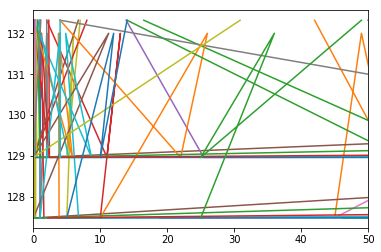

In [52]:
predictions = model.predict(X_trial)
model_names = ['Ball Park Franks', 'Oscar Mayer', 'Hebrew National', 'Veggie Dog']

plt.plot(X_trial, predictions)
plt.xlim(0, 50)
plt.savefig('multivariateRegression.png', bbox_inches='tight')

for prediction, name in zip(predictions, model_names):
    print(f'Ideal cook time for {name} is {prediction}')